Text(0.5, 1.0, 'D:-1024 - 3071')

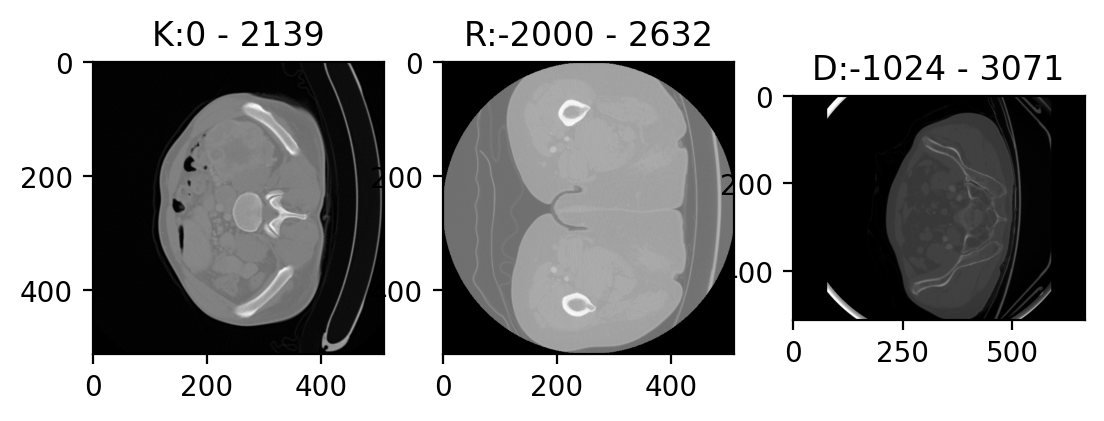

In [82]:

plt.figure(dpi=200)
plt.subplot(1,3,1)
plt.imshow(K, cmap="gray")
plt.title('K:'+ str(np.min(K)) + ' - ' + str(np.max(K)))
plt.subplot(1,3,2)
plt.imshow(R, cmap="gray")
plt.title('R:'+ str(np.min(R)) + ' - ' + str(np.max(R)))
plt.subplot(1,3,3)
plt.imshow(D, cmap="gray")
plt.title('D:'+ str(np.min(D)) + ' - ' + str(np.max(D)))

Text(0.5, 1.0, 'D:0 - 2139')

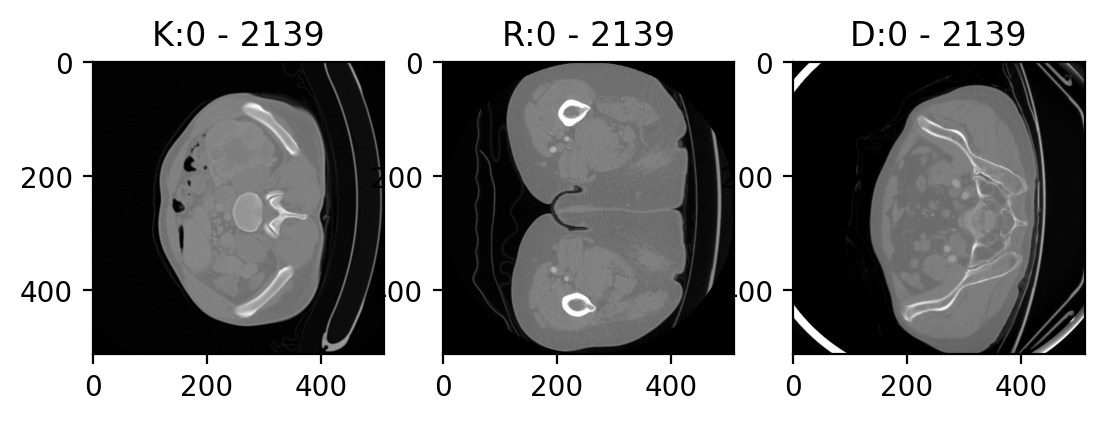

In [92]:

plt.figure(dpi=200)
plt.subplot(1,3,1)
plt.imshow(K, cmap="gray")
plt.title('K:'+ str(np.min(K)) + ' - ' + str(np.max(K)))
plt.subplot(1,3,2)
plt.imshow(R, cmap="gray")
plt.title('R:'+ str(np.min(R)) + ' - ' + str(np.max(R)))
plt.subplot(1,3,3)
plt.imshow(Dnew, cmap="gray")
plt.title('D:'+ str(np.min(D)) + ' - ' + str(np.max(D)))

In [80]:
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [81]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    RandAffined,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob

print_config()

MONAI version: 1.3.1+10.g4029c422
Numpy version: 1.26.4
Pytorch version: 2.3.0+cu118
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 4029c422f1da84cdf5e4ce546dbff33245cbe025
MONAI __file__: c:\Users\<username>\AppData\Local\Programs\Python\Python310\lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: 5.3.0
Nibabel version: 5.2.1
scikit-image version: 0.23.2
scipy version: 1.13.0
Pillow version: 10.3.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.18.0+cpu
tqdm version: 4.66.2
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.8
pandas version: 2.2.2
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: 1.0.0
clearml version: NOT INSTALLED or UNKNOWN VERSION

In [82]:
import SimpleITK as sitk
import os
import glob

In [83]:
import random

In [84]:
train_images = sorted(glob.glob(os.path.join("c:\\Users\\OskarK\\Desktop\\My_AVT2\\imagesTr", "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join("c:\\Users\\OskarK\\Desktop\\My_AVT2\\labelsTr", "*.seg.nii.gz")))
temp = list(zip(train_images, train_labels))
random.Random(10).shuffle(temp)
train_images, train_labels = zip(*temp)
data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]
train_files, val_files = data_dicts[:-14], data_dicts[-14:]
val_files

[{'image': 'c:\\Users\\OskarK\\Desktop\\My_AVT2\\imagesTr\\R13.nii.gz',
  'label': 'c:\\Users\\OskarK\\Desktop\\My_AVT2\\labelsTr\\R13.seg.nii.gz'},
 {'image': 'c:\\Users\\OskarK\\Desktop\\My_AVT2\\imagesTr\\K5.nii.gz',
  'label': 'c:\\Users\\OskarK\\Desktop\\My_AVT2\\labelsTr\\K5.seg.nii.gz'},
 {'image': 'c:\\Users\\OskarK\\Desktop\\My_AVT2\\imagesTr\\R4.nii.gz',
  'label': 'c:\\Users\\OskarK\\Desktop\\My_AVT2\\labelsTr\\R4.seg.nii.gz'},
 {'image': 'c:\\Users\\OskarK\\Desktop\\My_AVT2\\imagesTr\\D2.nii.gz',
  'label': 'c:\\Users\\OskarK\\Desktop\\My_AVT2\\labelsTr\\D2.seg.nii.gz'},
 {'image': 'c:\\Users\\OskarK\\Desktop\\My_AVT2\\imagesTr\\D9.nii.gz',
  'label': 'c:\\Users\\OskarK\\Desktop\\My_AVT2\\labelsTr\\D9.seg.nii.gz'},
 {'image': 'c:\\Users\\OskarK\\Desktop\\My_AVT2\\imagesTr\\K3.nii.gz',
  'label': 'c:\\Users\\OskarK\\Desktop\\My_AVT2\\labelsTr\\K3.seg.nii.gz'},
 {'image': 'c:\\Users\\OskarK\\Desktop\\My_AVT2\\imagesTr\\K2.nii.gz',
  'label': 'c:\\Users\\OskarK\\Desktop\\My_AV

In [97]:
val_files[i]['image'][:31] +"\\models\\"+val_files[i]['image'][40:-6]+"nrrd"

'c:\\Users\\OskarK\\Desktop\\My_AVT2\\models\\\\K5.nrrd'

In [85]:
set_determinism(seed=0)

In [86]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-1000,
            a_max=2000,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            #spatial_size=(144, 144, 96),
            spatial_size = (96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        # user can also add other random transforms
        # RandAffined(
        #     keys=['image', 'label'],
        #     mode=('bilinear', 'nearest'),
        #     prob=1.0, spatial_size=(96, 96, 96),
        #     ),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-1000,
            a_max=2000,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    ]
)

monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.


In [87]:
import numpy as np

image shape: torch.Size([256, 256, 318]), label shape: torch.Size([256, 256, 318])


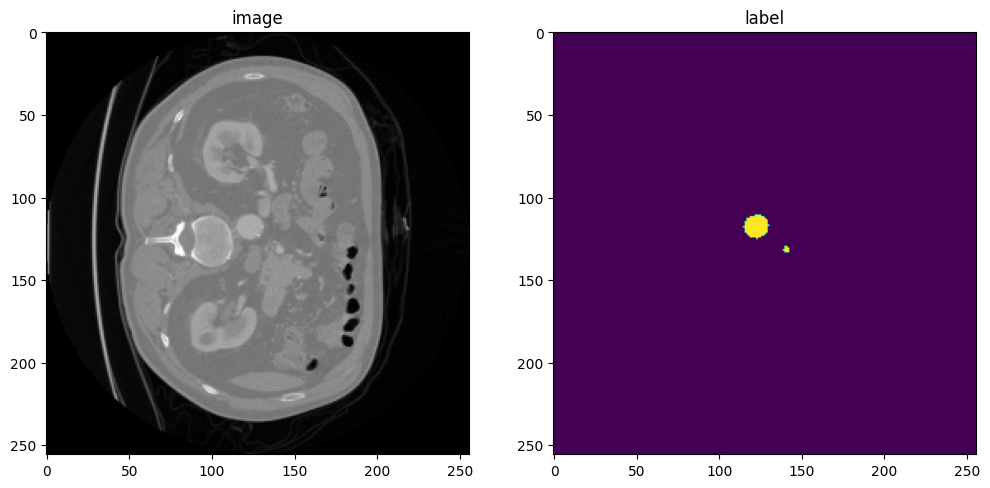

In [88]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
# image = image.numpy()
# image = (image-np.min(image))/(np.max(image)-np.min(image))
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 150], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 150])
plt.show()

In [89]:
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4)
# train_ds = Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
# val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

Loading dataset: 100%|██████████| 14/14 [00:41<00:00,  2.93s/it]


In [90]:
print(torch.cuda.is_available())

True


In [91]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

1
NVIDIA GeForce RTX 2070 SUPER


In [92]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

In [75]:
max_epochs = 600
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), 'c:\\Users\\OskarK\\Desktop\\My_AVT2\\best_metric_model.pth')
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

----------
epoch 1/600


Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)


1/18, train_loss: 0.6500
2/18, train_loss: 0.6479
3/18, train_loss: 0.6391
4/18, train_loss: 0.6629
5/18, train_loss: 0.6493
6/18, train_loss: 0.6296
7/18, train_loss: 0.6511
8/18, train_loss: 0.6461
9/18, train_loss: 0.6486
10/18, train_loss: 0.6411
11/18, train_loss: 0.6178
12/18, train_loss: 0.6523
13/18, train_loss: 0.6441
14/18, train_loss: 0.6317
15/18, train_loss: 0.6407
16/18, train_loss: 0.6441
17/18, train_loss: 0.6501
18/18, train_loss: 0.6246
epoch 1 average loss: 0.6428
----------
epoch 2/600
1/18, train_loss: 0.6404
2/18, train_loss: 0.6414
3/18, train_loss: 0.6374
4/18, train_loss: 0.6437
5/18, train_loss: 0.6398
6/18, train_loss: 0.6165
7/18, train_loss: 0.6291
8/18, train_loss: 0.6229
9/18, train_loss: 0.6238
10/18, train_loss: 0.6381
11/18, train_loss: 0.6266
12/18, train_loss: 0.6378
13/18, train_loss: 0.6282
14/18, train_loss: 0.6309
15/18, train_loss: 0.6308
16/18, train_loss: 0.6341
17/18, train_loss: 0.6357
18/18, train_loss: 0.6216
epoch 2 average loss: 0.6322
s

In [76]:
print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.8317 at epoch: 598


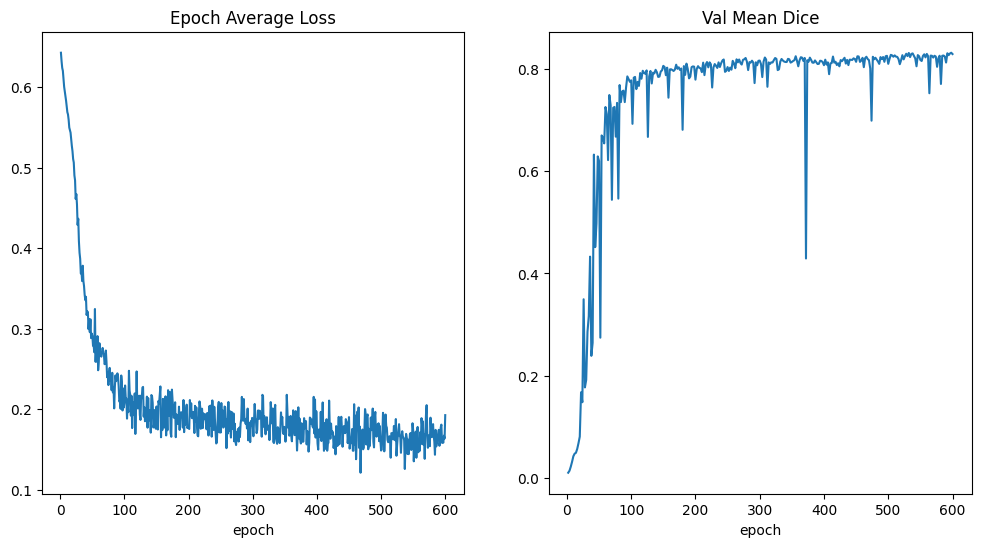

In [77]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

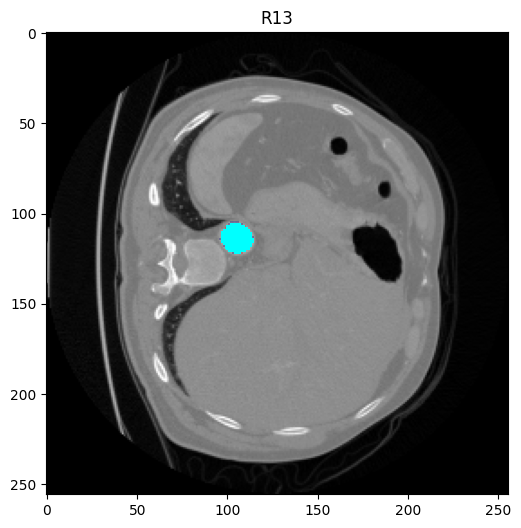

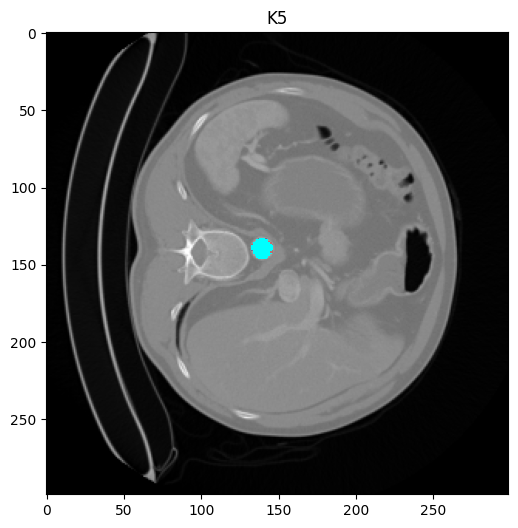

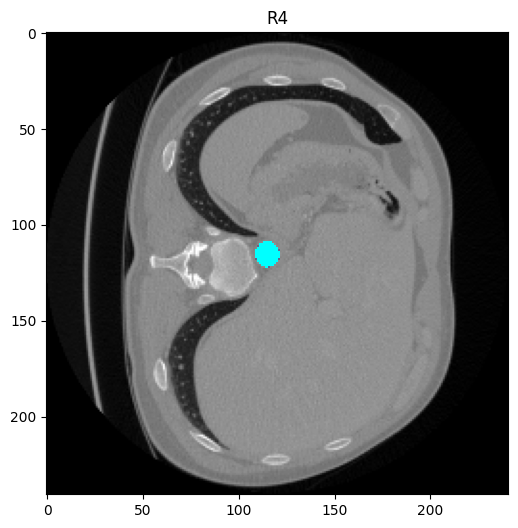

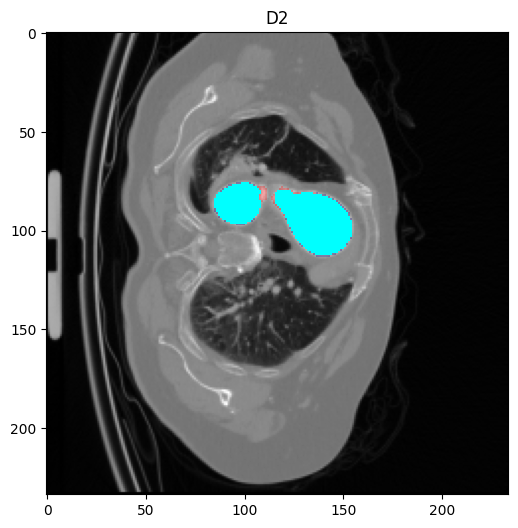

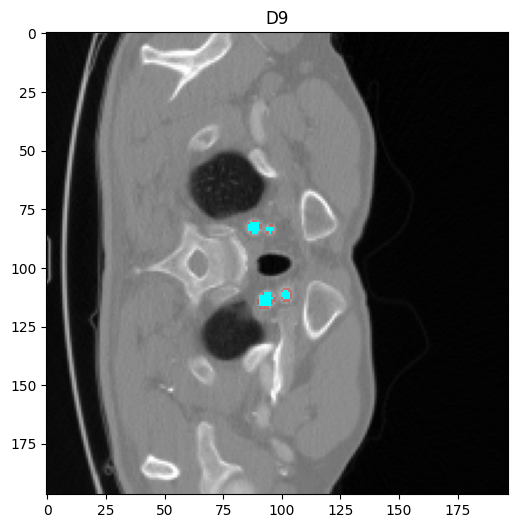

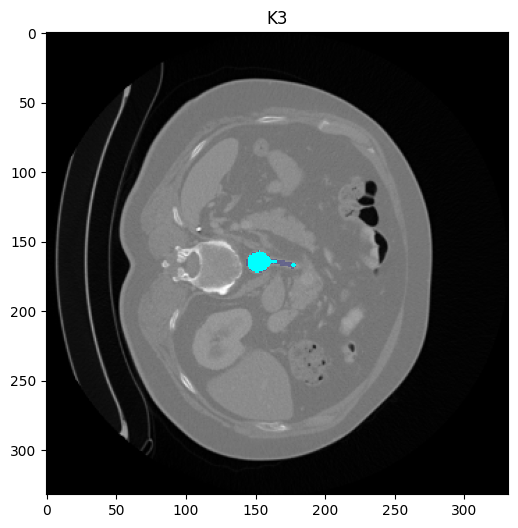

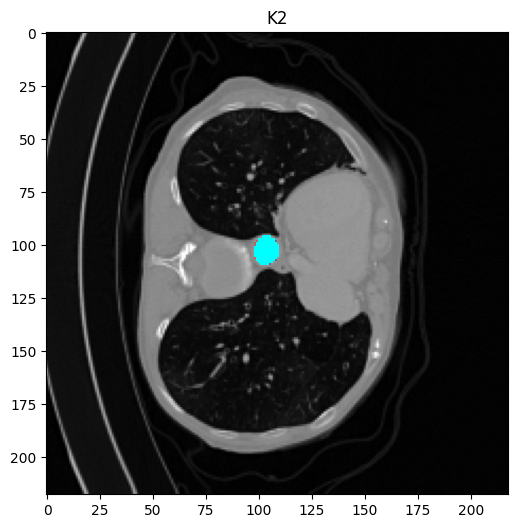

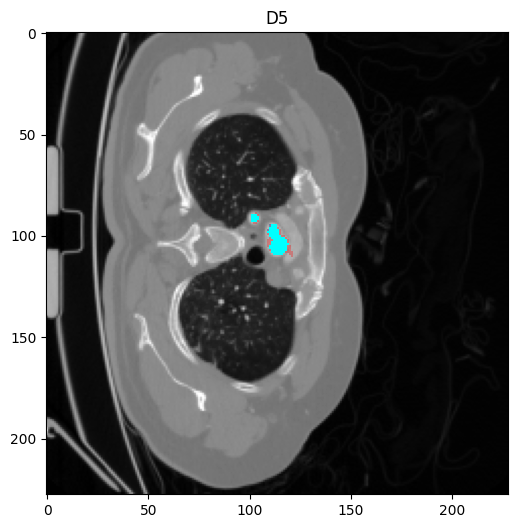

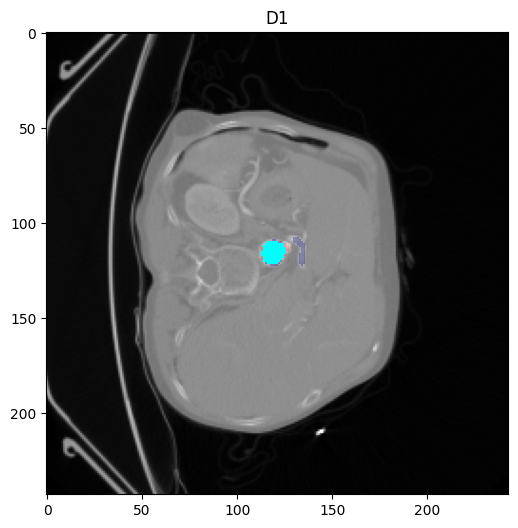

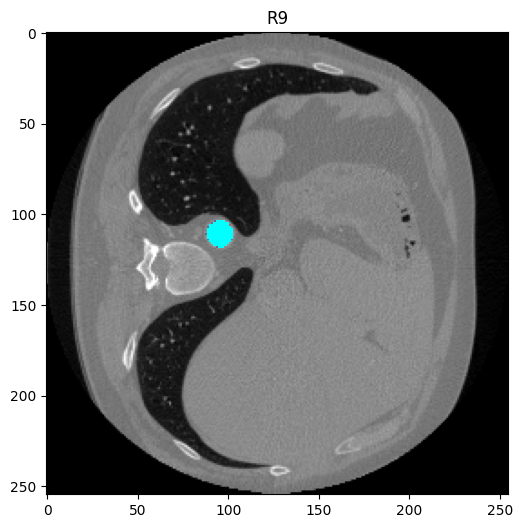

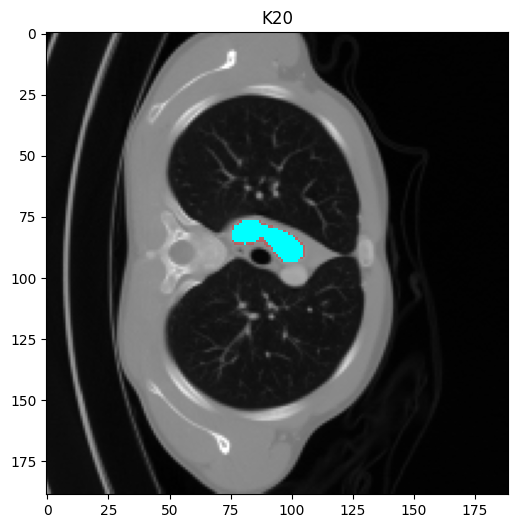

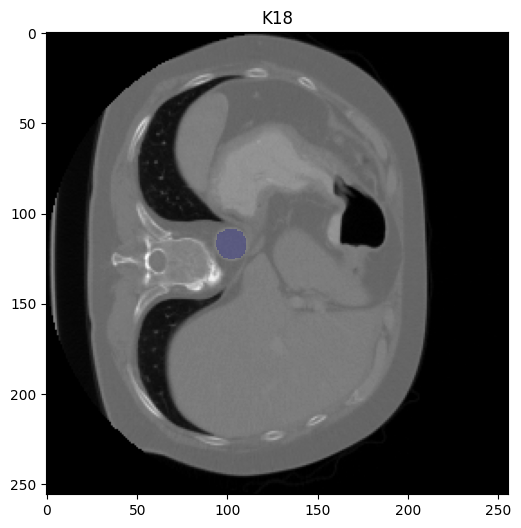

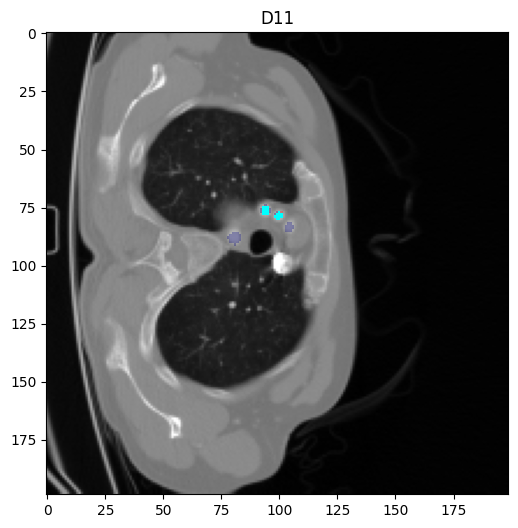

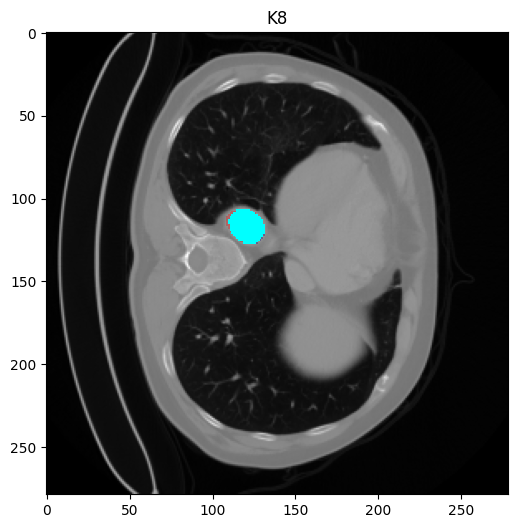

In [150]:
import nrrd
import numpy as np


model.load_state_dict(torch.load('c:\\Users\\OskarK\\Desktop\\My_AVT2\\best_metric_model.pth'))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_data["image"].to(device), roi_size, sw_batch_size, model)
        slice = 200
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        # plt.subplot(1, 3, 2)
        # plt.title(f"label")
        # plt.imshow(val_data["label"][0, 0, :, :, slice], cmap="gray")
        plt.subplot(1, 1, 1)
       
        mask = val_data["label"][0, 0, :, :, slice]
        mask2 = torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice]
        mask3 = np.logical_and(mask,mask2)

        masked = np.ma.masked_where(mask == 0, mask)
        masked2 = np.ma.masked_where(mask2 == 0, mask2)
        masked3 = np.ma.masked_where(mask3 == 0, mask3)

        plt.imshow(val_data["image"][0, 0, :, :, slice], cmap="gray")
        plt.title(val_files[i]['image'][41:-7])
        plt.imshow(masked, 'jet', interpolation='none', alpha=0.3)
        plt.imshow(masked2, 'prism', interpolation='none', alpha=0.3)
        plt.imshow(masked3, 'cool', interpolation='none', alpha=1)
        # plt.imshow(val_data["label"][0, 0, :, :, 150])
        # plt.subplot(1, 3, 3)
        # plt.title(f"output")
        # plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice],cmap='gray')
        plt.savefig(val_files[i]['image'][41:-7]+".png")
        plt.show()
        
        
        # name = val_files[i]['image'][:31] +"\\models\\"+val_files[i]['image'][40:-6]+"nrrd"
        
        # nrrd.write(name, torch.argmax(val_outputs, dim=1).detach().cpu().numpy()[0, :, :, :])
            
        if i == 13:
            break
        #cold - true, blue - false negative red - false positive